### 1. Prepare pkgs

In [8]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-whitegrid')
plt.rc('figure',autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large',
      titleweight = 'bold', titlesize = 18,
      titlepad = 10)
plt.rc('animation',html = 'html5')

In [9]:
import pandas as pd  
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

### 2. Load File and Preprocessing

#### 2-1-1 Continuous

In [4]:
spotify = pd.read_csv('Documents/spotify.csv')
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X.track_artist

In [5]:
feature_nums = X.select_dtypes(exclude = 'object').columns.to_list()

In [6]:
feature_nums

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

In [7]:
feature_cat = ['playlist_genre']

In [8]:
preprocessor = make_column_transformer(
                (StandardScaler(),feature_nums),
                (OneHotEncoder(),feature_cat),
                )

In [11]:
def group_split(X,y,group,train_size): # split by group in case of data leakage
    splitter = GroupShuffleSplit(train_size = train_size)
    train, test, = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [16]:
X_train, X_valid, y_train, y_valid = group_split(X,y, artists,.75)

#### 2-1-2 Discrete

In [4]:
# load some extra pkgs
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [22]:
hotel = pd.read_csv('Documents/hotel.csv')
X = hotel.copy()
y = X.pop('is_canceled')

In [23]:
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

In [24]:
# make preprocesser
transformer_num = make_pipeline(
    SimpleImputer(strategy = 'constant'),
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'),)

# combine
preprocessor = make_column_transformer(
                (transformer_num, features_num),
                (transformer_cat, features_cat),
)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify = y,
                                                     train_size = .75)
# stratify and shuffle in train_test_split():
# stratify to make sure equal proprotions of class in samples
# shuffle 

#### 2-2 Transform data

In [26]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

### 3. Compile & Run Model
**temper parameters**

In [27]:
input_shape = [X_train.shape[1]] # in list

In [28]:
model = keras.Sequential([
        layers.BatchNormalization(input_shape = input_shape), # (un)comment
        #layers.Dense(128, activation='relu',# may use layers.Activation
         #            input_shape = input_shape),
        layers.Dense(256, activation='relu'), # for classification
        layers.BatchNormalization(),
        layers.Dropout(.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(.3),
        #layers.Dense(64, activation='relu'),
        #layers.Dense(1) # output layer, if binary, use activation = 'sigmoid' to transform into probability
        layers.Dense(1, activation='sigmoid')
])

In [29]:
model.compile(
            optimizer = 'adam',
            #loss = 'mae', # 'binary_crossentropy' if classification
            loss = 'binary_crossentropy', # 'mae' if continuous
            metrics = ['binary_accuracy']
)

In [30]:
Early_stopping = callbacks.EarlyStopping(
                    min_delta= .001,
                    patience = 5,
                    restore_best_weights= True) # save time and prevent overfitting

In [31]:
history = model.fit(X_train, y_train,
                   validation_data = (X_valid, y_valid),
                   batch_size = 512, # samples to use in each run
                   epochs = 200, # total runs
                   callbacks = [Early_stopping],)

Train on 89542 samples, validate on 29848 samples
Epoch 1/200
89542/89542 [==============================] - 3s 30us/sample - loss: 0.4841 - binary_accuracy: 0.7702 - val_loss: 0.4330 - val_binary_accuracy: 0.7969
Epoch 2/200
89542/89542 [==============================] - 3s 37us/sample - loss: 0.4247 - binary_accuracy: 0.7992 - val_loss: 0.4021 - val_binary_accuracy: 0.8105
Epoch 3/200
89542/89542 [==============================] - 3s 39us/sample - loss: 0.4099 - binary_accuracy: 0.8072 - val_loss: 0.3938 - val_binary_accuracy: 0.8168
Epoch 4/200
89542/89542 [==============================] - 3s 37us/sample - loss: 0.4026 - binary_accuracy: 0.8119 - val_loss: 0.3906 - val_binary_accuracy: 0.8198
Epoch 5/200
89542/89542 [==============================] - 3s 36us/sample - loss: 0.3973 - binary_accuracy: 0.8143 - val_loss: 0.3852 - val_binary_accuracy: 0.8236
Epoch 6/200
89542/89542 [==============================] - 3s 36us/sample - loss: 0.3927 - binary_accuracy: 0.8171 - val_loss: 0.3

### 4. Visualization

In [32]:
history_df = pd.DataFrame(history.history) # logs 

<AxesSubplot:title={'center':'Accuracy'}>

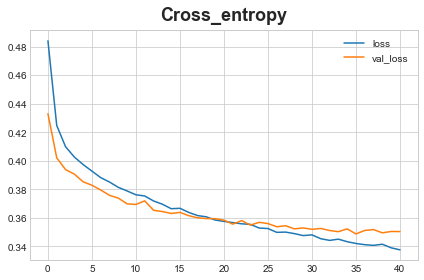

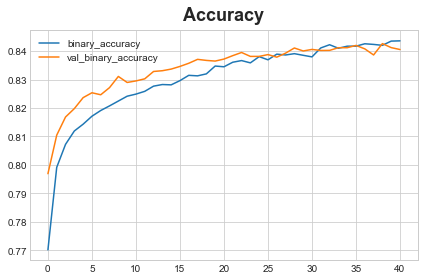

In [33]:
# history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['loss','val_loss']].plot(title = 'Cross_entropy')
history_df.loc[:,['binary_accuracy', 'val_binary_accuracy']].plot(title = 'Accuracy')

In [34]:
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Minimum Validation Loss: 0.3487


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'abs',
 'accumulate_n',
 'acos',
 'acosh',
 'add',
 'add_n',
 'angle',
 'argmax',
 'argmin',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'bessel_i0',
 'bessel_i0e',
 'bessel_i1',
 'bessel_i1e',
 'betainc',
 'bincount',
 'ceil',
 'confusion_matrix',
 'conj',
 'cos',
 'cosh',
 'count_nonzero',
 'cumprod',
 'cumsum',
 'cumulative_logsumexp',
 'digamma',
 'divide',
 'divide_no_nan',
 'equal',
 'erf',
 'erfc',
 'erfinv',
 'exp',
 'expm1',
 'floor',
 'floordiv',
 'floormod',
 'greater',
 'greater_equal',
 'igamma',
 'igammac',
 'imag',
 'in_top_k',
 'invert_permutation',
 'is_finite',
 'is_inf',
 'is_nan',
 'is_non_decreasing',
 'is_strictly_increasing',
 'l2_normalize',
 'lbeta',
 'less',
 'less_equal',
 'lgamma',
 'log',
 'log1p',
 'log_sigmoid',
 'log_softmax',
 'logical_and',
 'logical_not',
 'logical_or',
 'logical_xor',
 'maximum',
 'minimum',
 '